## Variance Inflation Factor(VIF)
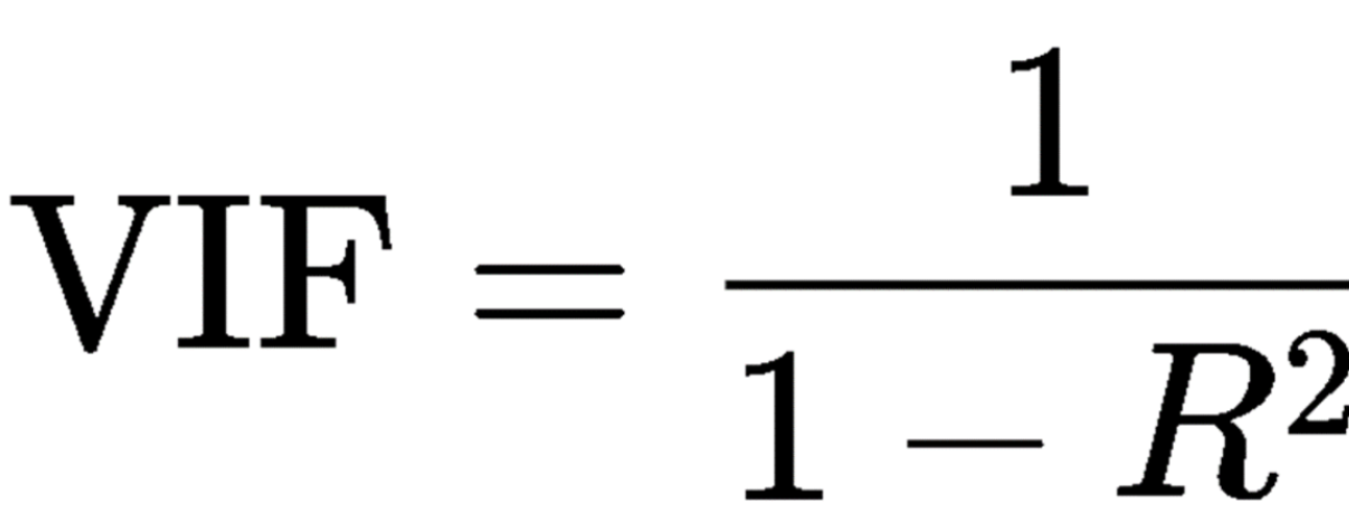
R^2越靠近1表示X2與X3越能表示X1 表示共線機率大

VIF越大表示共線性越大

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [5]:
data = pd.read_csv("BMI.csv")
print(data.head())
#Male = 0 Female = 1
data["Gender"] = data["Gender"].map({"Male":0,"Female":1})
print(data.head())

   Gender  Height  Weight  Index
0    Male     174      96      4
1    Male     189      87      2
2  Female     185     110      4
3  Female     195     104      3
4    Male     149      61      3
   Gender  Height  Weight  Index
0       0     174      96      4
1       0     189      87      2
2       1     185     110      4
3       1     195     104      3
4       0     149      61      3


In [ ]:
X = data[["Gender","Height","Weight"]]
X.values
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values,i) for i in range(len(X.columns))]
vif_data
#Gender 跟其他的共線性不高
#vif 1 沒有共線性 >5 算高

,feature,VIF
0,Gender,2.028864
1,Height,11.623103
2,Weight,10.688377


# 小作業加入BMI



In [9]:
#加入BMI
#X["BMI"] = X["Weight"]/ (X["Height"]/100)**2
#移除 "Height","Weight"

## 特徵選取演算法

你這樣說大致上是正確的，我這邊再詳細說明一下這三種方法的原理和用途，方便你更清楚理解：

1. **Sequential Feature Selection (SFS) – 逐步特徵選擇**  
   - **方法原理：** 逐一加入特徵，並在每次加入一個特徵後計算模型分數，觀察是否有提升。  
   - **重點說明：** 每一次挑選加入的特徵都是在測試哪一個能使模型效能（例如準確率、決定係數等等）有最大的提升，直到達到預先設定的特徵數量。  

2. **Recursive Feature Elimination (RFE) – 遞迴特徵淘汰**  
   - **方法原理：** 從全部特徵開始，每次移除對預測影響最小的特徵，然後重新評估模型的表現。  
   - **重點說明：** 透過反覆移除不重要的特徵，可以找出對模型最有幫助的子集。  

3. **Permutation Feature Importance (PFI) – 置換特徵重要性**  
   - **方法原理：** 對單一特徵的值進行隨機打亂（保持其他特徵不變），再觀察模型效能下降的幅度。  
   - **重點說明：** 如果隨機打亂某個特徵的值後，模型分數大幅下降，表示這個特徵對模型預測非常重要；反之，影響較小的特徵則重要性較低。

總結來說，你的理解：  
- SFS 是一次加入一個特徵，檢查是否能提高分數；  
- RFE 是一次移除一個特徵，觀察對模型分數的影響；  
- PFI 是透過隨機打亂某個特徵的值來看其對分數的影響。  

這三者的描述都是對的，只是在實際應用上還需要根據不同的情況選擇適合的方法。希望這樣的解釋有幫助你更清楚這三種方法的原理與應用！
常見演算法：


Sequential Feature Selection(SFS)。循序加入最具影響力的特徵，直到特徵數達到要求的個數。

Recursive Feature Elimination (RFE) 。每次都移除最不重要的特徵

Permutation Feature Importance(PFI)。數據中某一特徵的值隨機打亂，其他特徵保持不變

# Sequential Feature Selection(SFS)

In [10]:
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
X,y = load_wine(return_X_y=True,as_frame=True)
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [17]:
X.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [19]:
len(X.columns)

13

In [23]:
y.value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.5, random_state=42)

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [14]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [15]:
clf.fit(X_train_std, y_train)

LogisticRegression()

In [16]:
clf.score(X_test_std, y_test)

0.9887640449438202

## 測試選取3個特徵的所有組合

In [24]:
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SequentialFeatureSelector

In [51]:
knn = KNeighborsClassifier(n_neighbors=11)
sfs = SequentialFeatureSelector(knn,n_features_to_select=3)
sfs.fit(X_train_std, y_train)
support = sfs.get_support()
support

array([False, False, False, False, False, False,  True, False, False,
        True,  True, False, False])

In [53]:
cs = X.columns
for i in range(len(X.columns)):
    print(f"{i} : {cs[i]} : {support[i]}")

0 : alcohol : False
1 : malic_acid : False
2 : ash : False
3 : alcalinity_of_ash : False
4 : magnesium : False
5 : total_phenols : False
6 : flavanoids : True
7 : nonflavanoid_phenols : False
8 : proanthocyanins : False
9 : color_intensity : True
10 : hue : True
11 : od280/od315_of_diluted_wines : False
12 : proline : False


In [54]:
X.columns.to_frame()[sfs.get_support()]

,0
flavanoids,flavanoids
color_intensity,color_intensity
hue,hue


In [55]:
columns_ndarry = X.columns.to_numpy()[sfs.get_support()]
columns_ndarry

array(['flavanoids', 'color_intensity', 'hue'], dtype=object)

In [56]:
sfs.transform(X_train_std).shape

(89, 3)

In [57]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(sfs.transform(X_train_std),y_train)

LogisticRegression()

In [58]:
clf.score(sfs.transform(X_test_std),y_test)

0.8539325842696629

# Recursive Feature Elimination (RFE)

In [59]:
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [60]:
X, y = load_wine(return_X_y=True, as_frame=True)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.5, random_state=42)

In [62]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [63]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [64]:
clf.fit(X_train_std, y_train)

LogisticRegression()

In [65]:
clf.score(X_test_std, y_test)

0.9887640449438202

## 測試選取3個特徵的所有組合

In [69]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# RFE 使用的評估演算法必須支援 coef_ or feature_importances_ 屬性，KNN 不適用

clf = LogisticRegression()
model = RFE(clf,n_features_to_select=3)
model.fit(X_train_std,y_train)
model.get_support()

array([False, False, False, False, False, False,  True, False, False,
        True, False, False,  True])

In [70]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()


In [71]:
clf.fit(model.transform(X_train_std),y_train)

LogisticRegression()

In [72]:
clf.score(model.transform(X_test_std),y_test)

0.9662921348314607

# Permutation Feature Importance(PFI)

In [74]:
from sklearn.datasets import load_wine
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [75]:
X, y = load_wine(return_X_y=True, as_frame=True)

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.5, random_state=42)

In [77]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [78]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [79]:
clf.fit(X_train_std, y_train)

LogisticRegression()

In [80]:
clf.score(X_test_std, y_test)

0.9887640449438202

In [87]:
from sklearn.inspection import permutation_importance

In [94]:
clf = KNeighborsClassifier()
clf.fit(X_train_std, y_train)
model = permutation_importance(clf,X_test_std,y_test,n_repeats=10)

model.importances_mean ,model.importances_std

(array([ 3.93258427e-02,  3.59550562e-02,  3.59550562e-02, -2.22044605e-17,
         4.49438202e-03, -5.61797753e-03,  8.98876404e-03, -6.74157303e-03,
         2.24719101e-03,  4.49438202e-02,  1.34831461e-02,  5.61797753e-03,
         5.39325843e-02]),
 array([0.02025591, 0.01651341, 0.01490618, 0.01507462, 0.01755112,
        0.01035904, 0.00979528, 0.00745309, 0.01210149, 0.01123596,
        0.01933107, 0.01528255, 0.02235927]))

In [95]:
# 特徵選取名稱
column_list = np.array(X.columns.to_list())
column_selected = []
for i in model.importances_mean.argsort()[::-1]:
    #標準差 在此表示每次計算特徵重要性的變化性 起伏的一個狀態 也可以說穩定性
    #特徵重要性平均數 - 2倍特徵重要性標準差 意思是 此特徵重要性平均 很穩定標準差不算大就算2倍標準差也沒超過
    #簡單來說就是2倍標準差沒超過平均數 算很穩定
    #另外表示特徵平均數是正的 表示正相關
    if model.importances_mean[i] - 2*model.importances_std[i] > 0:
        print(f"{column_list[i]} : {model.importances_mean[i]} : {model.importances_std[i]}")
        column_selected.append(column_list[i])

proline : 0.053932584269662895 : 0.02235926824958697
color_intensity : 0.044943820224719086 : 0.01123595505617978
ash : 0.03595505617977527 : 0.014906178833057995
malic_acid : 0.035955056179775256 : 0.01651341399629109


In [ ]:
X = X[column_selected]
X_train, X_test, y_train, y_test = train_test_split(X.values, y, test_size=0.5, random_state=42)

In [97]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [98]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

In [99]:
clf.fit(X_train_std, y_train)

LogisticRegression()

In [100]:
clf.score(X_test_std, y_test)

0.9213483146067416

# Scikit-learn PCA 實作
PCA 就是將「很多個可能重複或相關的特徵」濃縮成「幾個更精簡、更有代表性的特徵」，用更少的維度來表達原本複雜的資料。
假設你今天要評估學生的學習表現，你可能蒐集了很多成績：

- 數學
- 物理
- 化學
- 生物
- 英文
- 國文
- 歷史
- 地理
- 公民

這麼多科目的成績看起來很複雜，但其實你可以發現：

- 數學、物理、化學、生物，這些科目之間成績常常互相有關聯，代表著學生的「理科能力」。
- 國文、歷史、地理、公民這些科目之間也有密切相關，代表學生的「文科能力」。
- 英文成績可能獨立代表學生的「語言能力」。

這時候，**PCA做的事情** 就是幫你自動發現這些潛在的能力維度（例如「理科能力」、「文科能力」、「語言能力」），並把原本九科的成績精簡成兩到三個更簡單的指標，讓你更容易掌握學生整體的表現。